In [1]:
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import numpy as np
from models import unet_depthnet
from argparse import Namespace
MAX_DEPTH = 1500
MIN_DEPTH = 300

In [6]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


InvalidArgumentError: Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a, b)]]

Caused by op 'MatMul', defined at:
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-3a5be606bcc9>", line 5, in <module>
    c = tf.matmul(a, b)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2018, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4456, in mat_mul
    name=name)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/jaunt/users/trevor/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a, b)]]


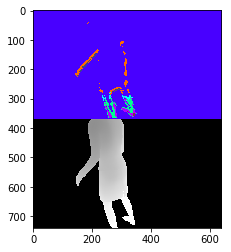

In [5]:
import matplotlib.pyplot as plt
img = plt.imread('out/unet_depthnet/imgs/test_2')
plt.imshow(img)
plt.show()

In [2]:
latest_checkpoint = tf.train.latest_checkpoint('experiments/unet_depthnet_small/checkpoints/best')

In [3]:
sess = tf.Session()
saver = tf.train.import_meta_graph(latest_checkpoint+'.meta')
saver.restore(sess, latest_checkpoint)

INFO:tensorflow:Restoring parameters from experiments/unet_depthnet_small/checkpoints/best/-130


In [4]:
base_path = '/jaunt/users/trevor/TFSegmentation/data/synthetic_seq/test_seq/'
file_name = 'man_1_punch_6_cam.h5'
f = h5py.File(base_path+file_name, 'r')

In [6]:
frame = '0050'
cam = 1

x_batch = []
y_batch = []
for key in list(f.keys()):
    if "FRAME" in key:
        group = f[key]
        y = group['RAW/CAM1/LABEL']
        x = group['RAW/CAM1/Z']
        x_batch.append(x)
        y_batch.append(y)

In [7]:
x_batch = np.array(x_batch, copy=False)
x_batch.clip(MIN_DEPTH, MAX_DEPTH, out=x_batch)
x_batch -= MIN_DEPTH
np.floor_divide(x_batch, (MAX_DEPTH - MIN_DEPTH + 1) / 256,
                out=x_batch, casting='unsafe')
x_batch= np.expand_dims(x_batch,3)

In [8]:

b_size = len(x_batch)

In [9]:
args = Namespace(abs_data_dir=None, batch_size=b_size, batchnorm_enabled=True, bias=0.0, checkpoint_best_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/checkpoints/best/', checkpoint_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/checkpoints/', config_path='unet_depthnet_train_small.yaml', data_dir='/jaunt/users/trevor/TFSegmentation/data/synthetic_seq/', data_mode='experiment', dropout_keep_prob=0.95, exp_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/', freeze_encoder=False, h5_train_file=None, h5_train_len=None, h5_val_file=None, h5_val_len=None, img_height=125, img_width=125, imgs_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/imgs/', learning_decay=1e-07, learning_decay_every=100, learning_rate=0.0001, max_to_keep=2, metrics_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/metrics/', mode='train', model='UNetDepthNet', momentum=0.9, npy_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/npy/', num_channels=1, num_classes=28, num_epochs=200, num_groups=3, operator='TrainPsy', out_dir='/jaunt/users/trevor/TFSegmentation/out/unet_depthnet_small/', pretrained_path='', random_cropping=False, save_every=10, shuffle=True, summary_dir='/jaunt/users/trevor/TFSegmentation/experiments/unet_depthnet_small/summaries/', targets_resize=None, test_every=10, tfrecord_train_file=None, tfrecord_train_len=None, tfrecord_val_file=None, tfrecord_val_len=None, train_data_len=2000, verbose=False, weight_decay=0.0005, weighted_loss=False, yaml_name=None)
model = unet_depthnet.UNetDepthNet(args)
model.build()



> /jaunt/users/trevor/TFSegmentation/models/unet_depthnet.py(13)__init__()
     12         import ipdb; ipdb.set_trace()
---> 13         self.encoder = None
     14 

ipdb> continue

Building the MODEL...
Building the DepthNet..
Layer_name: mobilenet_encoder/conv_1/cond/Merge -Output_Shape: [65, 63, 63, 32]
Layer_name: mobilenet_encoder/conv_2_1/pointwise/cond/Merge -Output_Shape: [65, 63, 63, 64]
Layer_name: mobilenet_encoder/conv_2_2/pointwise/cond/Merge -Output_Shape: [65, 32, 32, 128]
Layer_name: mobilenet_encoder/conv_3_1/pointwise/cond/Merge -Output_Shape: [65, 32, 32, 128]
Layer_name: mobilenet_encoder/conv_3_2/pointwise/cond/Merge -Output_Shape: [65, 16, 16, 256]
Layer_name: mobilenet_encoder/conv_4_1/pointwise/cond/Merge -Output_Shape: [65, 16, 16, 256]
Layer_name: mobilenet_encoder/conv_4_2/pointwise/cond/Merge -Output_Shape: [65, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_1/pointwise/cond/Merge -Output_Shape: [65, 8, 8, 512]
Layer_name: mobilenet_encoder/conv_5_2/pointw

In [19]:
feed_dict = {model.x_pl: x_batch,
             model.y_pl: y_batch,
             model.is_training: False
             }

In [20]:
init_op = tf.global_variables_initializer() 
sess.run(init_op)
out_argmax, segmented_imgs = sess.run(
                [model.out_argmax,
                 model.segmented_summary],
                feed_dict=feed_dict)

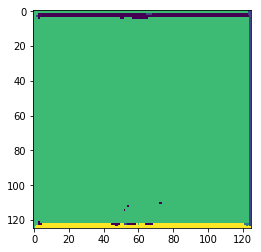

In [23]:
plt.imshow(out_argmax[2])
plt.show()

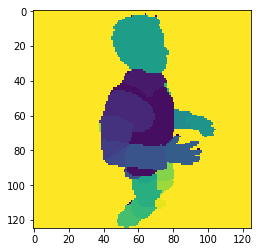

In [22]:
plt.imshow(y_batch[2])
plt.show()

In [37]:
sess.run(var[2])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [35]:
var[3]

<tf.Variable 'network/mobilenet_encoder/conv_1/batch_normalization/beta:0' shape=(32,) dtype=float32_ref>